In [33]:
import sys, os
sys.path.append(os.path.abspath(".."))

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from analysis.rules import evaluate_rules
from analysis.classifier import classify_behavior
from analysis.decision_engine import determine_severity, generate_alert


In [35]:
import pandas as pd
import numpy as np

N = 2000
np.random.seed(42)

df = pd.DataFrame({
    "today_minutes": np.random.randint(0, 400, N),
    "weekly_minutes": np.random.randint(200, 2500, N),
    "night_minutes": np.random.randint(0, 180, N),
    "sessions_per_day": np.random.randint(1, 30, N),
    "gaming_ratio": np.random.uniform(0.1, 1.5, N),
    "daily_threshold": 120,
    "night_threshold": 60
})

df.head()


,today_minutes,weekly_minutes,night_minutes,sessions_per_day,gaming_ratio,daily_threshold,night_threshold
0,102,1135,159,19,0.227895,120,60
1,348,2151,31,1,1.159305,120,60
2,270,441,5,2,0.915409,120,60
3,106,2243,175,16,0.361226,120,60
4,71,201,165,12,0.363525,120,60


In [36]:
from analysis.rules import evaluate_rules
from analysis.classifier import classify_behavior

def apply_engine(row):
    flags = evaluate_rules(row)
    state = classify_behavior(flags)
    return pd.Series([state, flags])

df[["state", "flags"]] = df.apply(apply_engine, axis=1)
df.head()


,today_minutes,weekly_minutes,night_minutes,sessions_per_day,gaming_ratio,daily_threshold,night_threshold,state,flags
0,102,1135,159,19,0.227895,120,60,Excessive,"{'daily_limit': 0, 'late_night': 1, 'frequency..."
1,348,2151,31,1,1.159305,120,60,Excessive,"{'daily_limit': 1, 'late_night': 0, 'frequency..."
2,270,441,5,2,0.915409,120,60,Excessive,"{'daily_limit': 1, 'late_night': 0, 'frequency..."
3,106,2243,175,16,0.361226,120,60,Excessive,"{'daily_limit': 0, 'late_night': 1, 'frequency..."
4,71,201,165,12,0.363525,120,60,Moderate,"{'daily_limit': 0, 'late_night': 1, 'frequency..."


C:\Users\mukhi\AppData\Local\Temp\ipykernel_6612\1914297862.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["state"], palette="viridis")


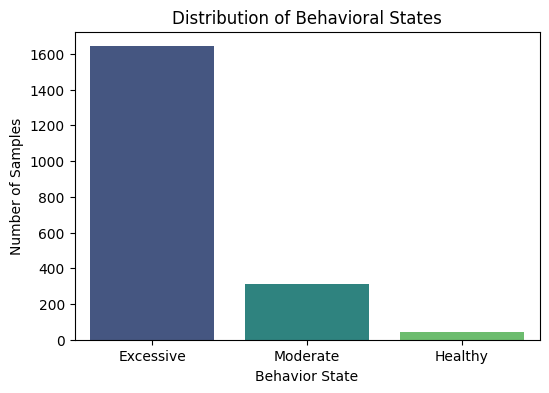

In [37]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["state"], palette="viridis")
plt.title("Distribution of Behavioral States")
plt.xlabel("Behavior State")
plt.ylabel("Number of Samples")
plt.show()


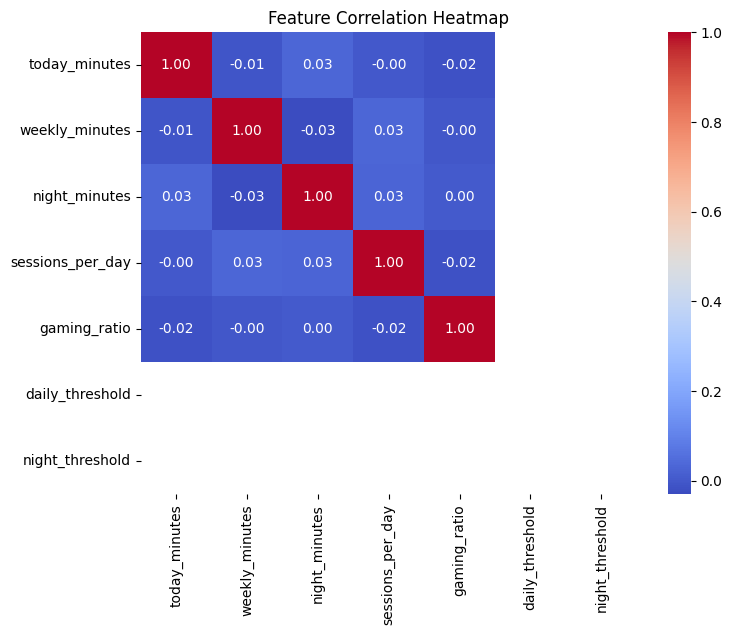

In [38]:
plt.figure(figsize=(8,6))
numeric_df = df.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


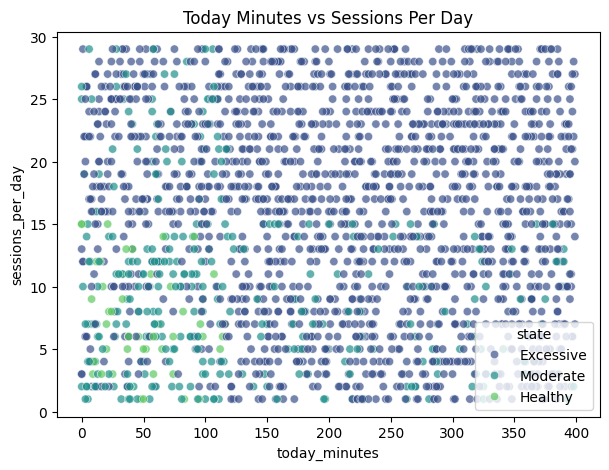

In [39]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df, 
    x="today_minutes", 
    y="sessions_per_day", 
    hue="state",
    palette="viridis",
    alpha=0.7
)
plt.title("Today Minutes vs Sessions Per Day")
plt.show()


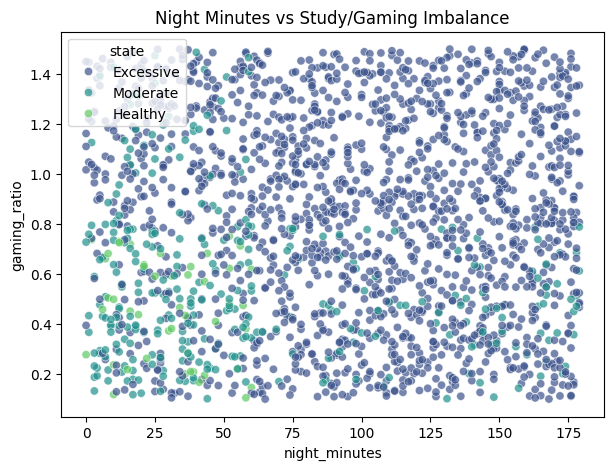

In [40]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df, 
    x="night_minutes", 
    y="gaming_ratio", 
    hue="state",
    palette="viridis",
    alpha=0.7
)
plt.title("Night Minutes vs Study/Gaming Imbalance")
plt.show()


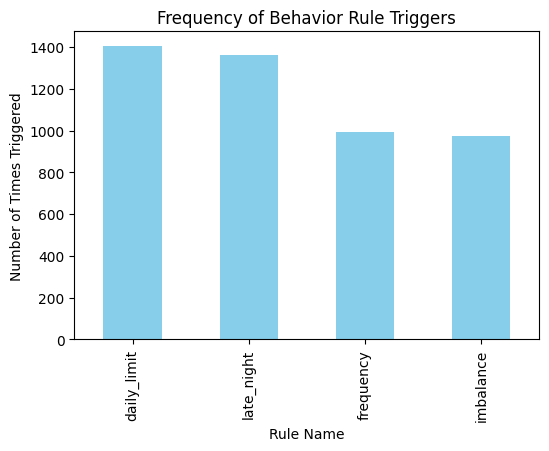

In [41]:
flag_counts = df["flags"].apply(lambda f: pd.Series(f)).sum()

plt.figure(figsize=(6,4))
flag_counts.plot(kind="bar", color="skyblue")
plt.title("Frequency of Behavior Rule Triggers")
plt.xlabel("Rule Name")
plt.ylabel("Number of Times Triggered")
plt.show()


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Features we will use for ML
X = df[[
    "today_minutes",
    "night_minutes",
    "sessions_per_day",
    "gaming_ratio"
]]

# Label
y = df["state"]

# Encode labels: Healthy=0, Moderate=1, Excessive=2
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42
)




In [44]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)



,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [45]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print(classification_report(
    y_test,
    y_pred,
    target_names=encoder.classes_
))


              precision    recall  f1-score   support

   Excessive       1.00      1.00      1.00       412
     Healthy       1.00      1.00      1.00        13
    Moderate       1.00      1.00      1.00        75

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



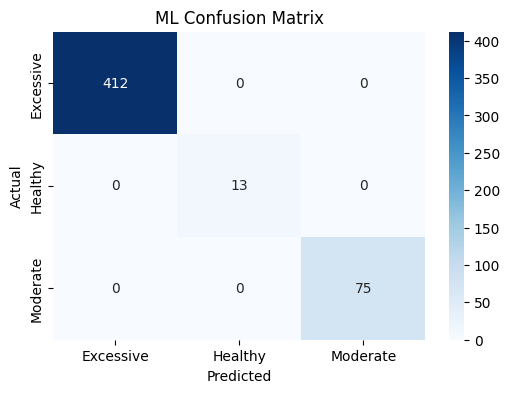

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.title("ML Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


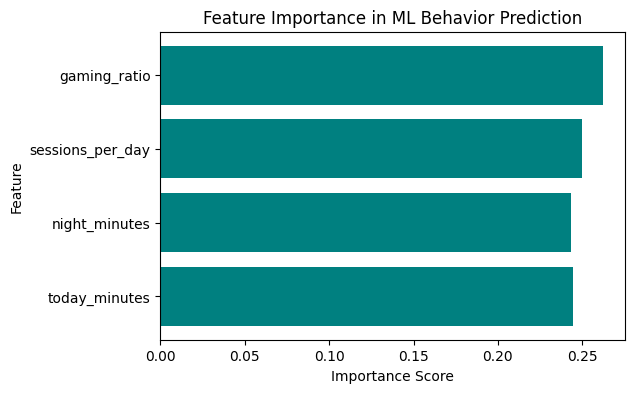

In [47]:
importance = model.feature_importances_

plt.figure(figsize=(6,4))
plt.barh(X.columns, importance, color="teal")
plt.title("Feature Importance in ML Behavior Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


In [48]:
import pickle

with open("../ml/model.pkl", "wb") as f:
    pickle.dump((model, encoder), f)

print("ML model saved at ml/model.pkl")


ML model saved at ml/model.pkl


In [49]:
import joblib
m = joblib.load("../ml/model.pkl")  # if notebook is inside /notebooks
print(type(m))
print(m)


<class 'tuple'>
(RandomForestClassifier(n_estimators=200, random_state=42), LabelEncoder())
